In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from skopt import gp_minimize

sns.set_style('darkgrid')

ModuleNotFoundError: No module named 'skopt'

In [2]:
dfTrainRaw = pd.read_csv('data/train.csv', index_col='PassengerId')
dfTestRaw = pd.read_csv('data/test.csv', index_col='PassengerId')

In [3]:
dfTrainRaw.nunique()

Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       147
Embarked      3
dtype: int64

In [4]:
dfTrainRaw.isna().sum()/dfTrainRaw.shape[0]*100

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

In [5]:
dfTestRaw.isna().sum()/dfTestRaw.shape[0]*100

Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         20.574163
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.239234
Cabin       78.229665
Embarked     0.000000
dtype: float64

In [6]:
dfTrainRaw.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
dfTrainRaw.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
dfTrainRaw.groupby('Survived')[['Embarked']].count(), dfTrainRaw.groupby('Survived')[['Sex']].count()

(          Embarked
 Survived          
 0              549
 1              340,
           Sex
 Survived     
 0         549
 1         342)

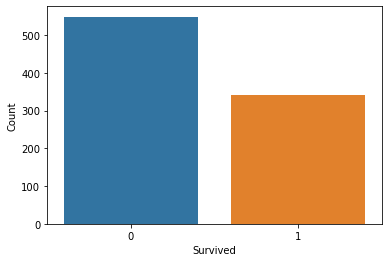

In [9]:
survivedCnt = dfTrainRaw.groupby('Survived')[['Survived']].count();
sns.barplot(x = survivedCnt.index,y = survivedCnt.Survived);
plt.ylabel('Count');

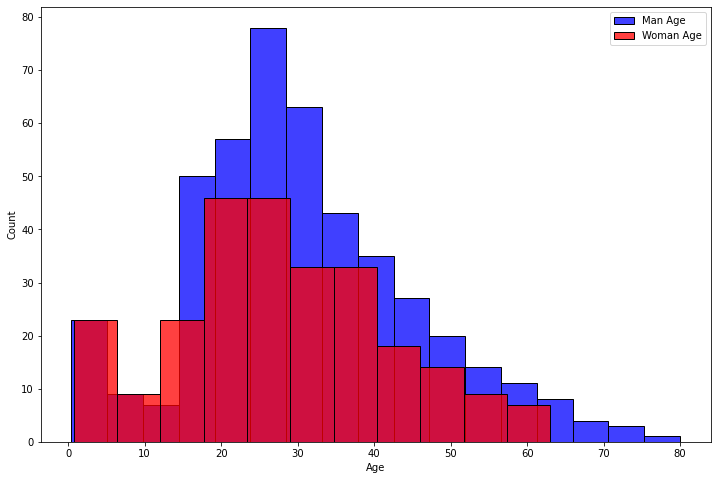

In [10]:
dfMan = dfTrainRaw[dfTrainRaw['Sex'] == 'male']
dfWoman = dfTrainRaw[dfTrainRaw['Sex'] == 'female']

plt.figure(figsize=(12,8))
sns.histplot(dfMan['Age'], label = 'Man Age',color=(0,0,1.0,0.2))
sns.histplot(dfWoman['Age'], label = 'Woman Age', color=(1,0,0,0.2))
plt.legend();

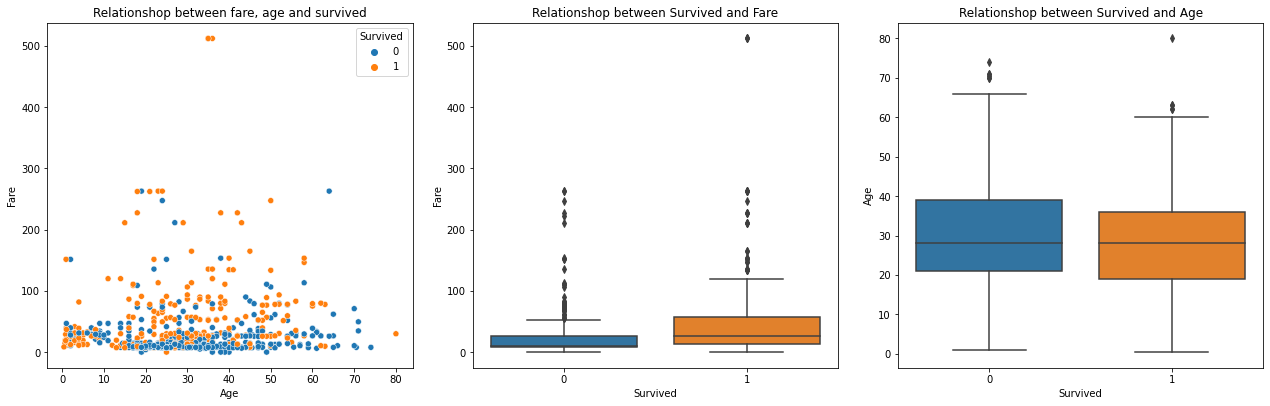

In [11]:
fig, ax = plt.subplots(1,3, figsize = (18,6))

sns.scatterplot(x = 'Age',y = 'Fare',hue = 'Survived', data = dfTrainRaw, ax = ax[0]);
ax[0].set_title('Relationshop between fare, age and survived')

sns.boxplot(x = 'Survived', y = 'Fare', data = dfTrainRaw, ax = ax[1])
ax[1].set_title('Relationshop between Survived and Fare')

sns.boxplot(x = 'Survived', y = 'Age', data = dfTrainRaw, ax = ax[2])
ax[2].set_title('Relationshop between Survived and Age')


plt.tight_layout(pad = 2)

<AxesSubplot:xlabel='Survived', ylabel='Count'>

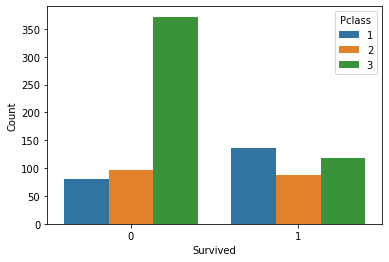

In [12]:
dfSurvivedByClass = pd.DataFrame(dfTrainRaw.groupby('Pclass')['Survived'].value_counts()).rename(columns={'Survived':'Count'}).reset_index()
sns.barplot(x = 'Survived', y = 'Count', hue = 'Pclass', data = dfSurvivedByClass)

In [13]:
dfTest = dfTrainRaw.copy()

# Function definitions

In [22]:
scaleData = True
def dataTransformation(df, train):
    colsDrop = ['Name','Ticket','Cabin']
    df1 = df.copy()
    df1.drop(colsDrop, axis = 1, inplace = True)
    df1['Sex'] = df1['Sex'].map(lambda x: 1 if x == 'male' else 0)
    imputer = SimpleImputer(strategy='mean')
    df1['Age'] = imputer.fit_transform(df1[['Age']])
    df1['Womand1sfClass'] = ((df1['Sex'] == 0) * (df1['Pclass'] == 1)).astype(int)
    df1['Womand2ndfClass'] = ((df1['Sex'] == 0) * (df1['Pclass'] == 2)).astype(int)
    df1['Womand3rdClass'] = ((df1['Sex'] == 0) * (df1['Pclass'] == 3)).astype(int)
    df1['Man1sfClass'] = ((df1['Sex'] == 1) * (df1['Pclass'] == 1)).astype(int)
    df1['Man2ndfClass'] = ((df1['Sex'] == 1) * (df1['Pclass'] == 2)).astype(int)
    df1['Man3rdClass'] = ((df1['Sex'] == 1) * (df1['Pclass'] == 3)).astype(int)
    df1['Child1sfClass'] = ((df1['Age'] <= 12) * (df1['Pclass'] == 1)).astype(int)
    df1['Child2ndfClass'] = ((df1['Age'] <= 12) * (df1['Pclass'] == 2)).astype(int)
    df1['Child3rdClass'] = ((df1['Age'] == 12) * (df1['Pclass'] == 3)).astype(int)
    df1['RatioAgeClass'] = df1['Age'] / df1['Pclass']
    df1['Embarked'] = df1['Embarked'].replace({'S':0,'C':1,'Q':2,np.nan:0})
    if scaleData == True:
        scaler = StandardScaler()
        if train == True:
            cols = df1.drop('Survived', axis = 1).columns
            df1 = pd.DataFrame(scaler.fit_transform(df1.drop('Survived', axis = 1)), columns=cols)
        else:
            cols = df1.columns
            df1 = pd.DataFrame(scaler.fit_transform(df1), columns=cols)
    if train == True:
        df1['Survived'] = df['Survived'].values
    return df1


def evaluateModel(model, dataset):
    scores = cross_val_score(estimator=model, X = dataset.drop('Survived', axis = 1), y = dataset['Survived'], cv = 3);
    return scores.mean()

In [16]:
dfTrainRaw.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
trainData = dataTransformation(dfTrainRaw, True)
trainData.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Womand1sfClass,Womand2ndfClass,Womand3rdClass,Man1sfClass,Man2ndfClass,Man3rdClass,Child1sfClass,Child2ndfClass,Child3rdClass,RatioAgeClass,Survived
0,0.827377,0.737695,-0.592481,0.432793,-0.473674,-0.502445,-0.568837,-0.343427,-0.305371,-0.439057,-0.398306,-0.371391,1.252088,-0.067153,-0.139466,-0.03352,-0.678269,0
1,-1.566107,-1.355574,0.638789,0.432793,-0.473674,0.786845,1.005181,2.911825,-0.305371,-0.439057,-0.398306,-0.371391,-0.798666,-0.067153,-0.139466,-0.03352,1.492513,1
2,0.827377,-1.355574,-0.284663,-0.474545,-0.473674,-0.488854,-0.568837,-0.343427,-0.305371,2.277608,-0.398306,-0.371391,-0.798666,-0.067153,-0.139466,-0.03352,-0.583887,1
3,-1.566107,-1.355574,0.407926,0.432793,-0.473674,0.420730,-0.568837,2.911825,-0.305371,-0.439057,-0.398306,-0.371391,-0.798666,-0.067153,-0.139466,-0.03352,1.280154,1
4,0.827377,0.737695,0.407926,-0.474545,-0.473674,-0.486337,-0.568837,-0.343427,-0.305371,-0.439057,-0.398306,-0.371391,1.252088,-0.067153,-0.139466,-0.03352,-0.371528,0


In [20]:
modelRF = RandomForestClassifier(n_estimators=100, random_state=0)
modelLogistic = LogisticRegression(random_state=0, penalty='l2')
modelSVM = SVC(kernel='poly', degree=3)
modelBoost = XGBClassifier(eta = 0.155, gamma = 0.2,max_depth = 10, min_child_weight=6)

modelNN = MLPClassifier()


models = {'RF': modelRF, 'Logistic':modelLogistic, 'xgb':modelBoost}
for key, model in models.items():
    score = evaluateModel(model,trainData);
    print(f'Modelo = {key}, accuracy = {score}')


Modelo = RF, accuracy = 0.8024691358024691
Modelo = Logistic, accuracy = 0.8260381593714926
[02:06:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:06:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:06:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to rest

c:\Users\Rodrigo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Rodrigo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Rodrigo\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The u

In [62]:
def treinarModelo(params):
    eta = params[0]
    gamma = params[1]
    max_depth = params[2]
    min_child_weight = params[3]


    model = XGBClassifier(eta = eta, gamma = gamma, max_depth = max_depth, min_child_weight = min_child_weight)
    scores = evaluateModel(model, trainData)
    return (1 - scores.mean())

space = [(0.01,0.3),
        (0,0.2),
        (3,10),
        (1,8)]

In [63]:
resultado = gp_minimize(treinarModelo,space, random_state=1, verbose=0, n_calls=30, n_initial_points = 10)

In [64]:
resultado.x

[0.1552347103829054, 0.2, 10, 6]

In [23]:
modelBoost = XGBClassifier(eta = 0.14, gamma = 0.046,max_depth = 7, min_child_weight=7)

X = trainData.drop('Survived', axis = 1)
y = trainData['Survived']

X_test = dataTransformation(dfTestRaw, False)

modelBoost.fit(X,y)
pred = modelBoost.predict(X_test)

KeyError: "['Survived'] not found in axis"

In [53]:
predTrain = modelBoost.predict(X)
accuracy_score(predTrain,y)

0.8900112233445566

In [40]:
submission = pd.DataFrame({'Survived':pred}, index = dfTestRaw.index)
submission.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0


In [33]:
submission.to_csv('submission.csv')

In [94]:
modelLog = LogisticRegression(random_state=0)

X = trainData.drop('Survived', axis = 1)
y = trainData['Survived']

X_test = dataTransformation(dfTestRaw, False)

modelLog.fit(X,y)
pred = modelLog.predict(X_test)

In [95]:
submission = pd.DataFrame({'Survived':pred}, index = dfTestRaw.index)
submission.to_csv('submission.csv')